In [0]:
# install requirements:
!pip install lightgbm

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/bin/python -m pip install --upgrade pip' command.


In [0]:
import pandas as pd
import numpy as np
import pyspark.pandas as ps
from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar, nearest_workday
from dateutil.easter import easter

import lightgbm as lgb
# import dask_xgboost as xgb
from sklearn import preprocessing, metrics
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit

In [0]:
# File location and type
file_location = "dbfs:/FileStore/shared_uploads/hectormotsepe@gmail.com/eskom_data_v1-1.csv" # eskom data --> current date 
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

In [0]:
display(df)

Date Time Hour Beginning,Original Res Forecast before Lockdown,Residual Forecast,RSA Contracted Forecast,Dispatchable Generation,Residual Demand,RSA Contracted Demand,International Exports,International Imports,Thermal Generation,Nuclear Generation,Eskom Gas Generation,Eskom OCGT Generation,Hydro Water Generation,Pumped Water Generation,ILS Usage,Manual Load_Reduction(MLR),IOS Excl ILS and MLR,Dispatchable IPP OCGT,Eskom Gas SCO,Eskom OCGT SCO,Hydro Water SCO,Pumped Water SCO Pumping,Wind,PV,CSP,Other RE,Total RE,Wind Installed Capacity,PV Installed Capacity,CSP Installed Capacity,Other RE Installed Capacity,Total RE Installed Capacity,Installed Eskom Capacity,Total PCLF,Total UCLF,Total OCLF,Total UCLF+OCLF,Non Comm Sentout,Drakensberg Gen Unit Hours,Palmiet Gen Unit Hours,Ingula Gen Unit Hours
2018-04-01 12:00:00 AM,null,19904.967,20367.066,20237.0,20237.0,20722.058,1215.902,1120.0,19444.0,931.0,0.0,0.0,360.0,0.0,0.0,0.0,0.0,0.0,-2.0,-2.0,0.0,-1614.0,454.964,0.0,17.555,12.539,485.058,2077.72,1474.19,300.0,21.78,3873.69,44546.0,3987.472,8028.71,275.907,8304,617,383.0,81.8,36.9
2018-04-01 01:00:00 AM,null,19553.899,19988.733,19744.0,19744.0,20188.493,1203.474,1106.0,19297.0,930.0,0.0,0.0,360.0,0.0,0.0,0.0,0.0,0.0,-2.0,-2.0,0.0,-1945.0,392.958,0.0,39.131,12.404,444.493,2077.72,1474.19,300.0,21.78,3873.69,44546.0,3987.472,7727.302,244.907,7972,209,388.0,83.0,38.5
2018-04-01 02:00:00 AM,null,19314.284,19731.239,19631.0,19631.0,20019.603,1177.571,1117.0,19165.0,931.0,0.0,0.0,360.0,0.0,0.0,0.0,0.0,0.0,-2.0,-2.0,0.0,-1938.0,337.358,0.0,39.163,12.082,388.603,2077.72,1474.19,300.0,21.78,3873.69,44546.0,3987.472,7704.704,193.727,7898,431,388.0,83.8,40.3
2018-04-01 03:00:00 AM,null,19342.679,19753.554,19731.0,19731.0,20079.454,1184.312,1118.0,19279.0,930.0,0.0,0.0,360.0,0.0,0.0,0.0,0.0,0.0,-2.0,-2.0,0.0,-1952.0,297.234,0.0,38.942,12.278,348.454,2077.72,1474.19,300.0,21.78,3873.69,44546.0,3990.072,7702.868,187.0,7889,868,389.0,85.0,42.0
2018-04-01 04:00:00 AM,null,19538.89,19988.365,19890.0,19890.0,20237.49,1197.271,1108.0,19369.0,930.0,0.0,0.0,360.0,0.0,0.0,0.0,0.0,0.0,-2.0,-2.0,0.0,-1873.0,309.978,0.0,25.024,12.488,347.49,2077.72,1474.19,300.0,21.78,3873.69,44546.0,3990.472,7685.115,187.0,7872,115,385.0,85.8,43.7
2018-04-01 05:00:00 AM,null,20103.838,20600.806,20372.0,20372.0,20729.45,1270.385,1125.0,19342.0,931.0,0.0,0.0,360.0,0.0,0.0,0.0,0.0,0.0,-2.0,-2.0,0.0,-1382.0,345.302,0.0,0.0,12.148,357.45,2077.72,1474.19,300.0,21.78,3873.69,44546.0,4017.139,7724.264,187.0,7911,264,384.0,87.0,45.6
2018-04-01 06:00:00 AM,null,21036.213,21560.2,21280.0,21280.0,21636.397,1289.362,1178.0,19363.0,931.0,0.0,0.0,360.0,0.0,0.0,0.0,0.0,0.0,-2.0,-2.0,0.0,-548.0,335.408,8.849,0.0,12.14,356.397,2077.72,1474.19,300.0,21.78,3873.69,44546.0,4054.472,7588.141,187.0,7775,141,383.0,87.4,47.2
2018-04-01 07:00:00 AM,null,22681.703,23447.173,22651.0,22651.0,23317.205,1367.023,1214.0,19867.0,932.0,0.0,0.0,475.0,208.0,0.0,0.0,0.0,0.0,-2.0,-2.0,0.0,-41.0,364.519,289.484,0.257,11.945,666.205,2077.72,1474.19,300.0,21.78,3873.69,44546.0,4639.472,7473.138,187.0,7660,138,380.0,87.8,47.6
2018-04-01 08:00:00 AM,null,24013.352,25242.639,23677.0,23677.0,24814.033,1396.007,1236.0,20645.0,931.0,0.0,0.0,481.0,416.0,0.0,0.0,0.0,0.0,-2.0,-2.0,0.0,-28.0,325.85,757.341,42.06,11.782,1137.033,2077.72,1474.19,300.0,21.78,3873.69,44546.0,4639.472,7338.785,187.0,7525,785,384.0,87.4,47.2
2018-04-01 09:00:00 AM,null,24241.366,25795.037,24053.0,24053.0,25485.461,1395.675,1234.0,20880.0,931.0,0.0,0.0,362.0,679.0,0.0,0.0,0.0,0.0,-2.0,-2.0,0.0,-29.0,298.114,1023.372,98.601,12.374,1432.461,2077.72,1474.19,300.0,21.78,3873.69,44546.0,4639.472,7503.23,187.0,7690,23,386.0,87.4,46.0


In [0]:

# DATA OBSERVATIONS

  # 1. Some of the columns are the sum of other columns, be careful of these to avoid data leakage.
  
  # 2. To avoid data leakage: the supply and demand features have high correlation: Using supply as a feature could result in a model that simply learns the relationship between supply and demand, rather than capturing the underlying drivers of demand.
  
#   For example, if load shedding occurs at a specific time, the data on how much demand was reduced due to load shedding (i.e., MLR) would not be available until after the load shedding event is over and Eskom has collected and reported the data.
  
# PROJECT OBJECTIVES

   # Forecast Demand: 
       
   # Forecast Supply: 

   # Anomaly Detection
    
   # Prediction:  Predict downtime or stoppage of energy supply to meet demand.

# MODEL EVALUATION:
   
   # COMPARE THE RESULTS AGINST THE FOLLOWING COLUMNS
    
      # Residual Forecast
      # RSA Contracted Forecast

 # PROJECT OBJECTIVES

   # Forecast Demand:  To predict the future electricity demand for the given period.
       
   # Forecast Supply:  To predict the future electricity supply for the given period.

   # Anomaly Detection:  To identify any unusual or abnormal electricity demand or supply patterns.
    
   # Prediction:  Predict downtime or stoppage of energy supply to meet demand.
  
# FEATURE CATEORY:

  # Temporal Features 
  
           #  Date Time Hour Beginning
     
  # Interruptions features (Predict downtime):
  
           #    ILS Usage
           #    Manual Load_Reduction(MLR)
           #    IOS Excl ILS and MLR

  # Eskom Generators features
  
           # Drakensberg Gen Unit Hours
           # Palmiet Gen Unit Hours
           # Ingula Gen Unit Hours

  # Non Comm Sentout feature

          #  Might refer to  refers to the amount of electricity that is sent out from Eskom power stations to customers who are not on a commercial tariff. 

  # Supply/Generation
  
        # Thermal Generation, Nuclear Generation, Eskom Gas Generation
        # Eskom OCGT Generation, Hydro Water Generation, Pumped Water Generation
        # Wind, PV, CSP, Other RE
        # Dispatchable IPP OCGT, Eskom Gas SCO, Eskom OCGT SCO, Hydro Water SCO, Pumped Water SCO Pumping

  # Capacity Features
  
       # Wind Installed Capacity, PV Installed Capacity, CSP Installed Capacity, Other RE Installed Capacity
       # Installed Eskom Capacity
       # Dispatchable Generatio

  # Demand/ Features

      # Residual Demand
      # RSA Contracted Demand
  
  # Unplanned loss of production Features
  
      # PCLF, OCLF, and UCLF are measures of the unavailable energy of Eskom plant over a period of time. 
  

  # Expert and Imports Features

      # International Exports, International Imports

In [0]:
# We going to use pandas, our dataset can easily fit in memory. Spark  increase the processing speed of large datasets, but it can also introduce additional latency due to communication overhead.

df = df.toPandas()


# Data Type is Important, Date is an Object
display(df.info())

# Drop Null Values
df = df.drop('Original Res Forecast before Lockdown', axis=1)

# Test Dataset
evaluation_dataset = df[df.isna().any(axis=1)]

df = df.dropna()

display(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 42 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Date Time Hour Beginning               43824 non-null  object
 1   Original Res Forecast before Lockdown  24336 non-null  object
 2   Residual Forecast                      43824 non-null  object
 3   RSA Contracted Forecast                43824 non-null  object
 4   Dispatchable Generation                43680 non-null  object
 5   Residual Demand                        43680 non-null  object
 6   RSA Contracted Demand                  43680 non-null  object
 7   International Exports                  43680 non-null  object
 8   International Imports                  43680 non-null  object
 9   Thermal Generation                     43680 non-null  object
 10  Nuclear Generation                     43680 non-null  object
 11  Eskom Gas Gener

In [0]:
evaluation_dataset 

,Residual Forecast
Date Time Hour Beginning,
2023-03-26 00:00:00,19835.072
2023-03-26 01:00:00,19485.019
2023-03-26 02:00:00,19391.842
2023-03-26 03:00:00,19319.153
2023-03-26 04:00:00,19706.524
...,...
2023-03-31 19:00:00,26668.31
2023-03-31 20:00:00,25142.286
2023-03-31 21:00:00,24079.93


In [0]:
class SouthAfricanHolidays:

    def __init__(self, years):
        self.years = years
        
    def get_holidays(self):
      
      sa_holidays = pd.DataFrame(columns=[])
      
      for year in self.years:
        
        holidays = pd.DataFrame({
            'holiday': 'South African holidays',
            'ds': pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')
        })
        
        
        # Add New Year's Day
        holidays.loc[(holidays.ds.dt.month == 1) & (holidays.ds.dt.day == 1), 'holiday'] = "New Year's Day"
        
        # Add Human Rights Day
        holidays.loc[(holidays.ds.dt.month == 3) & (holidays.ds.dt.day == 21), 'holiday'] = "Human Rights Day"

         # Add Good Friday 
        easter = holidays.ds.dt.date + pd.offsets.Easter()
        good_friday = easter - pd.Timedelta(days=2)
        holidays.loc[holidays.ds == good_friday, 'holiday'] = "Good Friday"

        # Add Family Day
        family_day = easter + pd.Timedelta(days=1)
        holidays.loc[holidays.ds == family_day, 'holiday'] = "Family Day"

        # Add Freedom Day
        holidays.loc[(holidays.ds.dt.month == 4) & (holidays.ds.dt.day == 27), 'holiday'] = "Freedom Day"

        # Add Workers' Day
        holidays.loc[(holidays.ds.dt.month == 5) & (holidays.ds.dt.day == 1), 'holiday'] = "Workers' Day"

        # Add Youth Day
        holidays.loc[(holidays.ds.dt.month == 6) & (holidays.ds.dt.day == 16), 'holiday'] = "Youth Day"

        # Add National Women's Day
        holidays.loc[(holidays.ds.dt.month == 8) & (holidays.ds.dt.day == 9), 'holiday'] = "National Women's Day"

        # Add Heritage Day
        holidays.loc[(holidays.ds.dt.month == 9) & (holidays.ds.dt.day == 24), 'holiday'] = "Heritage Day"

        # Add Day of Reconciliation
        holidays.loc[(holidays.ds.dt.month == 12) & (holidays.ds.dt.day == 16), 'holiday'] = "Day of Reconciliation"

        # Add Christmas Day
        holidays.loc[(holidays.ds.dt.month == 12) & (holidays.ds.dt.day == 25), 'holiday'] = "Christmas Day"

        # Add Day of Goodwill
        holidays.loc[(holidays.ds.dt.month == 12) & (holidays.ds.dt.day == 26), 'holiday'] = "Day of Goodwill"

        # Set index to the holiday dates
        holidays.set_index('ds', inplace=True)
        
        sa_holidays = pd.concat([holidays, sa_holidays], axis=0)
      

      return sa_holidays

In [0]:
# DATA EHANCEMENT
def create_date_features(df):

  df['Timestamp'] = pd.to_datetime(df['Date Time Hour Beginning'])

  #     0. Get units of time from the timestamp

  df['min'] = df['Timestamp'].dt.minute
  df['hour'] = df['Timestamp'].dt.hour
  df['wday'] = df['Timestamp'].dt.dayofweek
  df['mday'] = df['Timestamp'].dt.day
  df['yday'] = df['Timestamp'].dt.dayofyear
  df['month'] = df['Timestamp'].dt.month
  df['year'] = df['Timestamp'].dt.year
  df['date'] =  df['Timestamp'].dt.date

  #     1. Get Calender Holidays 
  Years = df['year'].unique()
  sa_holidays = SouthAfricanHolidays(Years)
  df_with_dates = sa_holidays.get_holidays()

  df_with_dates.reset_index(level=0, inplace=True)
  df_with_dates.rename(columns={'ds': 'date'}, inplace=True)
  df_with_dates['date'] = pd.to_datetime(df_with_dates['date'])
  df['date'] = pd.to_datetime(df['date'])

  return pd.merge(df, df_with_dates, on='date', how='left')

merged_df_dates = create_date_features(df)

In [0]:
import re

# 2. Get Economic/Social Factors (Interest Rate, Inflation Rate, Cost of Electricty, Population)

# 2.1 Get CPI data (Inflation)
def get_cpi_data(df):
  
  file_location = "dbfs:/FileStore/shared_uploads/hectormotsepe@gmail.com/cpi.csv"
  df_cpi = spark.read.format(file_type) \
    .option("inferSchema", infer_schema) \
    .option("header", first_row_is_header) \
    .option("sep", delimiter) \
    .load(file_location)
  
  display(df_cpi)
  # Sum the good prices and shape the dates
  for col_name in df_cpi.columns:
      if col_name.startswith("M"):
          df_cpi = df_cpi.withColumn(col_name, df_cpi[col_name].cast('float'))

  summed_prices = df_cpi.groupBy().sum() # sum(M201701)

  summed_prices = summed_prices.toPandas()

  summed_prices.columns = [re.sub(r'^sum\(M(\d+)\)$', r'\1', col) for col in summed_prices.columns]

  summed_prices = summed_prices.T.reset_index(0).rename(columns={'index': 'date', 0: 'Consumer_Price_Index'})

  summed_prices['date'] = pd.to_datetime(summed_prices['date'], format='%Y%m')

  summed_prices['month'] =  summed_prices['date'].dt.month
  summed_prices['year'] =  summed_prices['date'].dt.year

  merged_df_prices = df.merge(summed_prices,  on=['year', 'month'], how='left')

  merged_df_prices = merged_df_prices.drop(['date_y'], axis=1)

  merged_df_prices.rename(columns={'date_x': 'date'}, inplace=True)
  
  return merged_df_prices


merged_df_prices =  get_cpi_data(merged_df_dates)

H01,H02,H03,H04,H05,H06,H07,Weight (All urban),M201701,M201702,M201703,M201704,M201705,M201706,M201707,M201708,M201709,M201710,M201711,M201712,M201801,M201802,M201803,M201804,M201805,M201806,M201807,M201808,M201809,M201810,M201811,M201812,M201901,M201902,M201903,M201904,M201905,M201906,M201907,M201908,M201909,M201910,M201911,M201912,M202001,M202002,M202003,M202004,M202005,M202006,M202007,M202008,M202009,M202010,M202011,M202012,M202101,M202102,M202103,M202104,M202105,M202106,M202107,M202108,M202109,M202110,M202111,M202112,M202201,M202202,M202203,M202204,M202205,M202206,M202207,M202208,M202209,M202210,M202211,M202212,M202301,M202302
P0141,Consumer Price Index,01111001,Rice,Index,Dec 2021=100,monthly,0.37,92.2,91.5,91.5,89.8,89.1,90.4,89.5,89.3,90.7,91.0,89.3,88.0,90.3,89.9,90.3,89.9,90.3,90.4,91.4,91.0,90.1,90.9,91.5,91.3,93.5,94.1,93.5,93.8,93.8,94.7,94.6,95.6,96.3,95.6,96.8,96.5,98.2,98.2,97.7,92.7,92.8,98.3,95.9,99.2,98.5,100.4,101.2,101.8,102.6,103.4,102.8,102.2,101.8,102.6,103.1,102.8,102.0,102.0,102.2,100.0,100.6,100.9,101.6,100.1,100.3,102.4,99.2,102.5,106.3,107.1,106.4,107.8,107.3,109.2
P0141,Consumer Price Index,01112001,Loaf of white bread,Index,Dec 2021=100,monthly,0.44,86.8,86.6,86.7,87.2,86.5,86.7,86.7,85.5,84.8,84.5,84.7,84.7,85.0,86.6,86.0,86.3,85.8,86.5,86.2,86.6,88.0,87.8,88.0,88.6,89.6,91.6,92.6,92.7,93.1,93.2,92.6,92.0,91.7,91.5,91.5,90.7,90.4,91.6,91.9,93.0,93.2,95.3,97.3,97.6,97.4,98.1,98.7,98.8,99.1,98.9,98.9,98.1,98.5,98.5,98.0,96.9,97.7,99.2,100.4,100.0,99.3,102.5,103.6,104.6,108.5,110.0,113.1,115.1,117.6,116.8,117.2,117.0,117.3,118.5
P0141,Consumer Price Index,01112002,Loaf of brown bread,Index,Dec 2021=100,monthly,0.57,82.8,82.5,82.0,82.3,82.7,82.9,83.0,82.1,81.2,81.6,80.7,81.3,81.7,82.6,81.9,81.8,81.3,82.1,80.7,83.0,83.4,83.6,84.1,84.5,87.1,89.7,90.1,90.3,91.0,91.0,90.5,89.3,89.7,90.2,89.7,89.2,89.2,89.8,90.1,92.6,92.7,94.5,96.6,96.4,96.6,97.0,97.9,97.8,97.4,97.4,96.5,96.5,96.9,96.3,96.5,96.9,96.9,98.6,100.0,100.0,100.3,102.8,104.0,104.3,107.8,111.2,113.3,115.8,118.4,118.6,118.7,118.7,120.2,120.6
P0141,Consumer Price Index,01112003,Sweet biscuits,Index,Dec 2021=100,monthly,0.06,68.8,69.4,70.2,71.5,75.5,75.3,75.4,74.9,74.4,75.1,73.5,73.0,72.5,72.8,70.7,74.3,74.2,74.0,74.3,73.6,75.7,75.5,75.1,74.0,77.4,76.3,73.6,73.8,78.3,79.5,79.8,79.7,81.9,79.5,78.8,80.2,84.2,85.3,85.3,86.2,89.7,92.3,91.6,92.7,94.0,94.5,94.9,95.7,97.1,94.1,95.4,97.0,98.9,100.1,98.3,99.3,99.1,100.3,100.4,100.0,100.6,101.9,104.7,106.5,106.4,106.7,107.2,108.3,112.2,118.4,118.0,118.1,114.8,115.2
P0141,Consumer Price Index,01112004,Savoury biscuits,Index,Dec 2021=100,monthly,0.01,78.9,81.5,83.0,81.9,86.0,86.2,86.2,85.8,83.0,83.5,80.1,81.5,85.2,85.2,81.2,82.1,84.4,85.1,83.3,81.6,81.6,82.6,84.3,82.7,84.5,84.7,85.2,82.2,84.9,89.1,88.1,86.5,90.3,88.6,89.1,91.0,91.7,92.4,91.6,91.4,90.6,94.0,93.1,93.2,94.5,94.2,94.7,95.6,96.2,94.3,96.5,97.5,99.4,100.3,100.9,99.5,98.2,99.9,99.5,100.0,99.9,100.9,103.6,104.6,105.7,105.6,104.6,107.8,110.9,116.8,117.9,116.9,119.5,124.3
P0141,Consumer Price Index,01112005,Bread rolls,Index,Dec 2021=100,monthly,0.05,75.2,75.4,75.4,75.7,76.1,76.6,77.1,76.2,78.0,78.5,79.2,79.6,80.2,80.3,80.4,80.5,81.7,81.9,82.0,82.7,82.5,83.4,83.7,84.0,84.1,84.9,85.6,85.3,85.7,87.0,88.0,89.0,89.2,89.7,89.4,89.7,88.8,89.7,90.1,90.1,90.1,90.9,90.1,91.0,91.3,92.1,92.9,93.9,95.9,96.8,96.8,96.9,96.2,95.9,96.2,96.2,95.4,98.0,98.4,100.0,100.8,101.0,102.0,103.4,105.4,104.1,106.2,106.9,107.7,109.4,116.0,118.3,116.8,120.7
P0141,Consumer Price Index,01112301,Rusks,Index,Dec 2021=100,monthly,0.02,86.2,87.0,87.4,85.9,82.2,77.3,77.9,79.8,77.2,86.2,85.0,86.9,89.1,87.0,88.6,89.4,84.0,82.1,79.1,82.4,84.0,88.5,89.0,89.4,90.3,89.7,88.5,89.7,84.5,88.0,85.8,90.6,91.4,91.4,93.3,94.4,95.6,93.1,95.3,95.3,93.8,87.9,85.6,86.6,88.7,92.1,93.2,93.4,93.8,95.2,96.3,95.1,95.0,94.8,96.2,95.5,96.3,100.1,99.1,100.0,101.0,101.6,101.4,101.3,102.3,103.7,106.3,110.1,114.9,116.0,112.9,113.8,113.9,121.6
P0141,Consumer Price Index,01113001,Spaghetti,Index,Dec 2021=100,monthly,0.0

In [0]:
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

# 2.1 GDP 

def create_economic_indicator(df_merge):
  
  file_location = "dbfs:/FileStore/shared_uploads/hectormotsepe@gmail.com/gdp.csv"
  
  df_gdp = spark.read.format(file_type) \
    .option("inferSchema", infer_schema) \
    .option("header", first_row_is_header) \
    .option("sep", delimiter) \
    .load(file_location)

  df_gdp = df_gdp.filter(df_gdp['` sa) `'].isNotNull())

  df_gdp = df_gdp.toPandas()

  df_gdp.columns = df_gdp.iloc[0]

  df_gdp = df_gdp.drop(0)
  
  # rename column 
  df_gdp = df_gdp.rename(columns={'Value': 'GDP_Value'})
   
  # extract dates
  df_gdp['year'] = '20' + df_gdp['Date'].str.slice(start=3) 
  df_gdp['Quarter'] = df_gdp['Date'].str.slice(stop=2)
  
  # Define mapping from quarter to month range
  quarter_to_month = {
      'Q1': [1,2,3],
      'Q2': [4,5,6],
      'Q3': [7,8,9],
      'Q4': [10, 11, 12]
  }

  # Map quarters to month ranges and expand into separate rows
  df_gdp['month'] = df_gdp['Quarter'].apply(lambda x: quarter_to_month[x])

  # Rename column to Month
  df_gdp = df_gdp.explode('month')
  
  df_gdp = df_gdp.drop(['Date', 'Quarter'], axis=1)
  
  df_gdp[['month', 'year']] = df_gdp[['month', 'year']].astype(int)
  
  df_merge = df_merge.merge(df_gdp, on=['month', 'year'], how='left')
  
  return df_merge


df_eco_ind = create_economic_indicator(merged_df_prices)

In [0]:
# 2.2 Gross Value Added (Water and Service)


def create_gva_indicator(df_merge):
  
  file_location = "dbfs:/FileStore/shared_uploads/hectormotsepe@gmail.com/gva__1_.csv"
  
  df_gdp = spark.read.format(file_type) \
    .option("inferSchema", infer_schema) \
    .option("header", first_row_is_header) \
    .option("sep", delimiter) \
    .load(file_location)

  df_gdp = df_gdp.toPandas()
  
  # rename column 
  df_gdp = df_gdp.rename(columns={'Value': 'GVA_Value'})
   
  # extract dates
  df_gdp['year'] = '20' + df_gdp['Date'].str.slice(start=3) 
  df_gdp['Quarter'] = df_gdp['Date'].str.slice(stop=2)
  
  # Define mapping from quarter to month range
  quarter_to_month = {
      'Q1': [1,2,3],
      'Q2': [4,5,6],
      'Q3': [7,8,9],
      'Q4': [10, 11, 12]
  }

  # Map quarters to month ranges and expand into separate rows
  df_gdp['month'] = df_gdp['Quarter'].apply(lambda x: quarter_to_month[x])

  # Rename column to Month
  df_gdp = df_gdp.explode('month')
  
  df_gdp = df_gdp.drop(['Date', 'Quarter'], axis=1)
  
  df_gdp[['month', 'year']] = df_gdp[['month', 'year']].astype(int)
  
  df_merge = df_merge.merge(df_gdp, on=['month', 'year'], how='left')
  
  return df_merge

df_eco_gva = create_gva_indicator(df_eco_ind)

In [0]:
# 2.3 Population (Water and Service)

def create_population_indicator(df_merge):
  
  file_location = "dbfs:/FileStore/shared_uploads/hectormotsepe@gmail.com/population.csv"
  
  df_gdp = spark.read.format(file_type) \
    .option("inferSchema", infer_schema) \
    .option("header", first_row_is_header) \
    .option("sep", delimiter) \
    .load(file_location)
  
  display(df_gdp)

  df_gdp = df_gdp.toPandas()
  
  # rename column 
  df_gdp = df_gdp.rename(columns={'Value': 'Population_Value'})

  df_gdp[['year']] = df_gdp[['Date']].astype(int)
  
  df_merge = df_merge.merge(df_gdp, on=['year'], how='left')
  
  df_merge = df_merge.drop(['Date'], axis=1)
  
  return df_merge

df_eco_population = create_population_indicator(df_eco_gva)

Date,Value
2022,60605
2021,59965
2020,59353
2019,58533
2018,57673


In [0]:
# Weather Features 
def get_weather_data(df):
  
  file_location = "dbfs:/FileStore/shared_uploads/hectormotsepe@gmail.com/south_african_weather_data.csv"
  df_weather = spark.read.format(file_type) \
    .option("inferSchema", infer_schema) \
    .option("header", first_row_is_header) \
    .option("sep", delimiter) \
    .load(file_location)
  
  df_weather = df_weather.toPandas()

  df_weather[['month']] = df_weather[['month']].astype(int)

  return df.merge(df_weather, on='month', how='left')

df_merge_weather = get_weather_data(df_eco_population)

month,sunshine_per_day,rains_per_month,relative_humidity,absolute_humidity,humidex
1,7.6,10.93,62,12.3,34
2,8,7,63,12.3,35
3,7.4,6.31,63,11.4,32
4,7.7,3.67,63,9.5,28
5,9,0.94,56,7.1,24
6,8.8,0.93,54,5.7,20
7,9.2,0.15,50,5.2,19
8,9.4,0.53,45,5.6,23
9,9.4,0.93,44,7.1,29
10,9,5.36,52,9.3,32


In [0]:
# Data Cleanisng and Processing

# 1. Impute Missing Values

count_null = df_merge_weather.isnull().sum()

count_null.sort_values(ascending=False)

# economic data, most likely wont drstically change in few hours
def data_cleansing_processing(df):
  
  df = df.fillna(method='ffill')
  
  # 2. Create Numeric values for text values
  df['holiday'] =  np.where(df["holiday"] == "South African holidays", 0, 1)
  
  return df

df_merge_weather_null = data_cleansing_processing(df_merge_weather)

In [0]:
    
# Cyclical variable transformations
def cyclical_variable(data):   
  
    # wday has period of 6
    data['wday_sin'] = np.sin(2 * np.pi * data['wday'] / 6)
    data['wday_cos'] = np.cos(2 * np.pi * data['wday'] / 6)
    
    # yday has period of 365
    data['yday_sin'] = np.sin(2 * np.pi * data['yday'] / 365)
    data['yday_cos'] = np.cos(2 * np.pi * data['yday'] / 365)
    
    # month has period of 12
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    
    # time has period of 24
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 23)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 23)
    
    return data

df_cyclical_features = cyclical_variable(df_merge_weather_null) 

In [0]:
from datetime import datetime

# Feature Engineering

def feature_engineering(data):
  
  forecast_rows = pd.DataFrame(index=pd.date_range(start=data['Date Time Hour Beginning'].iloc[-1], end='2023-03-31 12:00:00 PM', freq='H'))

  # Concatenate the empty rows with the original dataframe
  data = data.set_index('Date Time Hour Beginning')
  data = pd.concat([data, forecast_rows], axis=0)
    
  # demand features (Hourly/Days)
  data['lag_t24'] = data['Residual Demand'].transform(lambda x: x.shift(24))
  data['lag_t144'] = data['Residual Demand'].transform(lambda x: x.shift(144))
  data['lag_t68'] = data['Residual Demand'].transform(lambda x: x.shift(68))
  data['lag_t92'] = data['Residual Demand'].transform(lambda x: x.shift(92))
  data['lag_t48'] = data['Residual Demand'].transform(lambda x: x.shift(48))
  data['lag_t190'] = data['Residual Demand'].transform(lambda x: x.shift(120))
  
  data['rolling_mean_t1'] = data['Residual Demand'].transform(lambda x: x.shift(144).rolling(24).mean())
  data['rolling_std_t1'] = data['Residual Demand'].transform(lambda x: x.shift(144).rolling(24).std())
  
  data['rolling_mean_t8'] = data['Residual Demand'].transform(lambda x: x.shift(144).rolling(8).mean())
  data['rolling_std_t8'] = data['Residual Demand'].transform(lambda x: x.shift(144).rolling(8).std())
  
  data['rolling_mean_t8'] = data['Residual Demand'].transform(lambda x: x.shift(144).rolling(12).mean())
  data['rolling_std_t8'] = data['Residual Demand'].transform(lambda x: x.shift(144).rolling(12).std())
  
  data['rolling_mean_t30'] = data['Residual Demand'].transform(lambda x: x.shift(144).rolling(30).mean())
  data['rolling_std_t30'] = data['Residual Demand'].transform(lambda x: x.shift(144).rolling(30).std()) 
  
  data['rolling_mean_t90'] = data['Residual Demand'].transform(lambda x: x.shift(144).rolling(90).mean())
  data['rolling_std_t90'] = data['Residual Demand'].transform(lambda x: x.shift(144).rolling(90).std())
  
  data['rolling_mean_t180'] = data['Residual Demand'].transform(lambda x: x.shift(144).rolling(180).mean())
  data['rolling_std_t180'] = data['Residual Demand'].transform(lambda x: x.shift(144).rolling(180).std())
  
  data['rolling_mean_t720'] = data['Residual Demand'].transform(lambda x: x.shift(144).rolling(720).mean())
  data['rolling_std_t720'] = data['Residual Demand'].transform(lambda x: x.shift(144).rolling(720).std())

  # demand change
  data['lag_demand_t72'] = data['Residual Demand'].transform(lambda x: x.shift(72))
  data[['lag_demand_t72', 'Residual Demand']] = data[['lag_demand_t72','Residual Demand']].astype(float)
  
  data['demand_change_t72'] = (data['lag_demand_t72'] - data['Residual Demand']) / (data['lag_demand_t72'])
  data['demand_change_t72'] = data['demand_change_t72'].transform(lambda x: x.shift(72))
  
  data['lag_demand_t1'] = data['Residual Demand'].transform(lambda x: x.shift(144))
  data[['lag_demand_t1', 'Residual Demand']] = data[['lag_demand_t1','Residual Demand']].astype(float)
  data['demand_change_t1'] = (data['lag_demand_t1'] - data['Residual Demand']) / (data['lag_demand_t1'])
  data['demand_change_t1'] = data['demand_change_t1'].transform(lambda x: x.shift(144))
  
  data['rolling_demand_max_t144'] = data['Residual Demand'].transform(lambda x: x.shift(144).rolling(144).max())
  data['demand_change_t144'] = (data['rolling_demand_max_t144'] - data['Residual Demand']) / (data['rolling_demand_max_t144'])
  data['demand_change_t144'] = data['demand_change_t144'].transform(lambda x: x.shift(144))
  data.drop(['rolling_demand_max_t144', 'lag_demand_t1'], inplace = True, axis = 1)
  
  data['lag_demand_t192'] = data['Residual Demand'].transform(lambda x: x.shift(48))
  data[['lag_demand_t192', 'Residual Demand']] = data[['lag_demand_t192','Residual Demand']].astype(float)
  data['demand_change_t192'] = (data['lag_demand_t192'] - data['Residual Demand']) / (data['lag_demand_t192'])
  data['demand_change_t192'] = data['demand_change_t192'].transform(lambda x: x.shift(48))
  
  data['rolling_demand_max_t216'] = data['Residual Demand'].transform(lambda x: x.shift(144).rolling(12).max())
  data['demand_change_t216'] = (data['rolling_demand_max_t216'] - data['Residual Demand']) / (data['rolling_demand_max_t216'])
  data['demand_change_t216'] = data['demand_change_t216'].transform(lambda x: x.shift(144))
  data.drop(['rolling_demand_max_t216', 'lag_demand_t192'], inplace = True, axis = 1)
  

  data['rolling_demand_max_t720'] = data['Residual Demand'].transform(lambda x: x.shift(144).rolling(160).max())
  data['demand_change_t720'] = (data['rolling_demand_max_t720'] - data['Residual Demand']) / (data['rolling_demand_max_t720'])
  data['demand_change_t720'] = data['demand_change_t720'].transform(lambda x: x.shift(144))
  data.drop(['rolling_demand_max_t720'], inplace = True, axis = 1)
  

  return data
    

data_engineered_features = feature_engineering(df_cyclical_features) 

In [0]:
forecast_data

,Date Time Hour Beginning,Total RE Installed Capacity,Installed Eskom Capacity,Residual Demand,Consumer_Price_Index,GDP_Value,GVA_Value,Population_Value,lag_t24,lag_t144,...,rolling_std_t180,rolling_mean_t720,rolling_std_t720,lag_demand_t72,demand_change_t72,demand_change_t1,demand_change_t144,demand_change_t192,demand_change_t216,demand_change_t720
0,2023-03-25 11:00:00 PM,6280.24,46686.0,21038.521,24910.800034,6718015,97570,60605,20809.941,20119.068,...,2198.181282,24195.932878,2118.385956,21240.107,-0.055720,0.103216,0.304748,-0.042985,0.302528,0.304748
1,2023-03-25 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20353.845,19463.068,...,2224.394601,24193.332969,2123.045671,21234.769,-0.091029,0.115517,0.327417,-0.016413,0.325270,0.327417
2,2023-03-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19792.51,19193.341,...,2252.192577,24190.754381,2127.990590,20987.401,-0.093473,0.117559,0.336738,-0.012384,0.334621,0.336738
3,2023-03-26 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19762.375,18868.801,...,2283.735811,24187.963439,2133.651296,20769.267,-0.100720,0.131001,0.347953,0.005361,0.345872,0.347953
4,2023-03-26 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19734.002,18967.201,...,2314.150806,24185.142722,2139.209393,20944.809,-0.104265,0.135540,0.344553,-0.001274,0.342460,0.344553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,2023-03-31 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23879.727,...,2173.487468,24014.303971,2202.870532,NaN,NaN,-0.011508,0.172157,NaN,0.004117,0.172157
131,2023-03-31 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23823.45,...,2174.443238,24011.901376,2202.132878,NaN,NaN,-0.045723,0.174108,NaN,0.006464,0.174108
132,2023-03-31 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23351.742,...,2172.130531,24009.234607,2201.767576,NaN,NaN,-0.044765,0.190461,NaN,0.026136,0.190461
133,2023-03-31 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22914.251,...,2167.000320,24006.074174,2201.703822,NaN,NaN,-0.045821,0.205627,NaN,0.044381,0.205627


In [0]:
# Forecast Data (To be used for Future prediuctions)

forecast_data =  data_engineered_features.loc[df_cyclical_features['Date Time Hour Beginning'].iloc[-1]:]

# Reset the index of the dataframe and convert the index into a column
forecast_data = forecast_data.reset_index()

# The original index is now a column called 'index', so you can rename it if desired
forecast_data = forecast_data.rename(columns={'index': 'Date Time Hour Beginning '})

# filter training dataset:
data_engineered_features = data_engineered_features.loc[: df_cyclical_features['Date Time Hour Beginning'].iloc[-1]][:-1]

forecast_data = forecast_data.drop(forecast_data.columns[1], axis=1)

forecast_data = forecast_data.rename(columns={'Date Time Hour Beginning ' : 'Date Time Hour Beginning'})

forecast_data  = forecast_data[[
    'Date Time Hour Beginning',
  'Total RE Installed Capacity', 'Installed Eskom Capacity', 'Residual Demand',
  
  'Consumer_Price_Index', 'GDP_Value', 'GVA_Value', 'Population_Value',
  
        # lag featurers
       'lag_t24',
       'lag_t144', 'lag_t68', 'lag_t92', 'lag_t48', 'lag_t190',
    
       # rolling window feature
       'rolling_mean_t1', 'rolling_std_t1', 'rolling_mean_t8',
       'rolling_std_t8', 'rolling_mean_t30', 'rolling_std_t30',
       'rolling_mean_t90', 'rolling_std_t90', 'rolling_mean_t180',
       'rolling_std_t180', 'rolling_mean_t720', 'rolling_std_t720',
       'lag_demand_t72', 'demand_change_t72', 'demand_change_t1',
       'demand_change_t144', 'demand_change_t192', 'demand_change_t216',
       'demand_change_t720'
]]

In [0]:
# Demand Forecast Feature Selection:

# Residual Demand,	RSA Contracted Demand,	International Imports
select_features = [
  
       # capacy features
       'Total RE Installed Capacity', 'Installed Eskom Capacity',
        
       # economic/social factors features
       'Consumer_Price_Index', 'GDP_Value', 'GVA_Value', 'Population_Value', 
      
       # weather features
        'sunshine_per_day', 'rains_per_month', 'relative_humidity',
       'absolute_humidity', 'humidex', 
        
             # lag featurers
       'lag_t24',
       'lag_t144', 'lag_t68', 'lag_t92', 'lag_t48', 'lag_t190',
    
       # rolling window feature
       'rolling_mean_t1', 'rolling_std_t1', 'rolling_mean_t8',
       'rolling_std_t8', 'rolling_mean_t30', 'rolling_std_t30',
       'rolling_mean_t90', 'rolling_std_t90', 'rolling_mean_t180',
       'rolling_std_t180', 'rolling_mean_t720', 'rolling_std_t720',
       'lag_demand_t72', 'demand_change_t72', 'demand_change_t1',
       'demand_change_t144', 'demand_change_t192', 'demand_change_t216',
       'demand_change_t720',
       
  
        # Date Features
       'wday_sin', 'wday_cos', 'yday_sin', 'yday_cos', 'month_sin',
       'month_cos', 'hour_sin', 'hour_cos',  
  
       'date', 
  
       # south african holiday features
       'holiday',
  
       # Target
       'Residual Demand'
]

demand_dataset = data_engineered_features[select_features]

# convert all the columns to float except holidays
demand_dataset = demand_dataset.astype({col: float for col in demand_dataset.columns if col not in ['holiday', 'date']})

In [0]:
# split dataset

train_x = demand_dataset[demand_dataset['date'] <= '2023-03-17']
train_y = train_x.sort_values('date')['Residual Demand']
test_x = demand_dataset[(demand_dataset['date'] > '2023-03-17')]
train_x = train_x.sort_values('date')
test_x = test_x.sort_values('date')

In [0]:
# feature normalisation

# from sklearn.preprocessing import MinMaxScaler

# scaler =  MinMaxScaler()


# norm_features = [feature for feature in select_features if feature not in ['date','holiday','Residual Demand']]

# train_x[norm_features] = scaler.fit_transform(train_x[norm_features])
# test_x[norm_features] = scaler.transform(test_x[norm_features])

float_features = [feature for feature in select_features if feature not in ['date','holiday','Residual Demand']]

train_x[float_features] = train_x[float_features].astype('float')
test_x[float_features] = test_x[float_features].astype('float')

In [0]:
n_fold = 6 
folds = TimeSeriesSplit(n_splits=n_fold)

In [0]:
params = {'num_leaves': 555,
          'min_child_weight': 0.034,
          'feature_fraction': 0.379,
          'bagging_fraction': 0.418,
          'min_data_in_leaf': 106,
          'objective': 'tweedie',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'rmse',
          "verbosity": -1,
          'reg_alpha': 0.3899,
          'reg_lambda': 0.648,
          'random_state': 222,
         }

In [0]:
columns = [
     
  feature for feature in select_features if feature not in ['date', 'Residual Demand']
  
]

splits = folds.split(train_x, train_y)
y_preds = np.zeros(test_x.shape[0])
y_oof = np.zeros(train_x.shape[0])
feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
mean_score = []

In [0]:
for fold_n, (train_index, valid_index) in enumerate(splits):
  
    print('Fold:',fold_n+1)
    
    X_train, X_valid = train_x[columns].iloc[train_index], train_x[columns].iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    
    clf = lgb.train(params, dtrain, 2500, valid_sets = [dtrain, dvalid],early_stopping_rounds = 50, verbose_eval=100)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid,num_iteration=clf.best_iteration)
    y_oof[valid_index] = y_pred_valid
    
    val_score = np.sqrt(metrics.mean_squared_error(y_pred_valid, y_valid))
    
    print(f'val rmse score is {val_score}')
    
    mean_score.append(val_score)
    
    y_preds += clf.predict(test_x[columns], num_iteration=clf.best_iteration)/n_fold
    del X_train, X_valid, y_train, y_valid
    

print('mean rmse score over folds is',np.mean(mean_score))
test_x['demand'] = y_preds

Fold: 1
Training until validation scores don't improve for 50 rounds


/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[100]	training's rmse: 1423.52	valid_1's rmse: 1469.75
[200]	training's rmse: 853.652	valid_1's rmse: 1006.13
[300]	training's rmse: 660.126	valid_1's rmse: 884.011
[400]	training's rmse: 569.921	valid_1's rmse: 839.408
[500]	training's rmse: 509.65	valid_1's rmse: 817.514
[600]	training's rmse: 463.22	valid_1's rmse: 804.183
[700]	training's rmse: 427.81	valid_1's rmse: 795.465
[800]	training's rmse: 400.543	valid_1's rmse: 789.835
[900]	training's rmse: 377.604	valid_1's rmse: 787.05
[1000]	training's rmse: 358.016	valid_1's rmse: 785.285
[1100]	training's rmse: 340.951	valid_1's rmse: 784.386
[1200]	training's rmse: 326.183	valid_1's rmse: 783.354
Early stopping, best iteration is:
[1171]	training's rmse: 330.394	valid_1's rmse: 783.304
val rmse score is 783.3036355687932
Fold: 2
Training until validation scores don't improve for 50 rounds


/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[100]	training's rmse: 1376.68	valid_1's rmse: 2254.59
[200]	training's rmse: 812.473	valid_1's rmse: 1780.99
[300]	training's rmse: 621.833	valid_1's rmse: 1633.91
[400]	training's rmse: 536.948	valid_1's rmse: 1585.4
[500]	training's rmse: 479.437	valid_1's rmse: 1575.84
[600]	training's rmse: 435.588	valid_1's rmse: 1570.62
[700]	training's rmse: 400.422	valid_1's rmse: 1566.28
Early stopping, best iteration is:
[723]	training's rmse: 392.995	valid_1's rmse: 1565.42
val rmse score is 1565.4213786441462
Fold: 3


/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1426.85	valid_1's rmse: 1454.8
[200]	training's rmse: 819.371	valid_1's rmse: 979.626
[300]	training's rmse: 615.278	valid_1's rmse: 859.562
[400]	training's rmse: 526.098	valid_1's rmse: 832.496
[500]	training's rmse: 464.123	valid_1's rmse: 817.17
[600]	training's rmse: 420.127	valid_1's rmse: 813.633
[700]	training's rmse: 383.817	valid_1's rmse: 807.413
[800]	training's rmse: 355.445	valid_1's rmse: 804.742
Early stopping, best iteration is:
[803]	training's rmse: 354.592	valid_1's rmse: 804.653
val rmse score is 804.6528577698456
Fold: 4


/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1411.92	valid_1's rmse: 1355.52
[200]	training's rmse: 812.809	valid_1's rmse: 919.426
[300]	training's rmse: 612.958	valid_1's rmse: 813.765
[400]	training's rmse: 523.18	valid_1's rmse: 789.788
[500]	training's rmse: 462.691	valid_1's rmse: 786.63
Early stopping, best iteration is:
[454]	training's rmse: 488.758	valid_1's rmse: 784.814
val rmse score is 784.8140476535801
Fold: 5


/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1391.47	valid_1's rmse: 1345.07
[200]	training's rmse: 809.214	valid_1's rmse: 930.728
[300]	training's rmse: 615.437	valid_1's rmse: 824.006
[400]	training's rmse: 528.399	valid_1's rmse: 792.347
[500]	training's rmse: 467.732	valid_1's rmse: 780.237
[600]	training's rmse: 420.678	valid_1's rmse: 775.937
[700]	training's rmse: 381.282	valid_1's rmse: 774.385
Early stopping, best iteration is:
[741]	training's rmse: 367.423	valid_1's rmse: 773.836
val rmse score is 773.8364995200957
Fold: 6


/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1374.35	valid_1's rmse: 1300.49
[200]	training's rmse: 805.721	valid_1's rmse: 882.925
[300]	training's rmse: 616.904	valid_1's rmse: 776.495
[400]	training's rmse: 531.966	valid_1's rmse: 745.309
[500]	training's rmse: 471.155	valid_1's rmse: 733.076
[600]	training's rmse: 424.303	valid_1's rmse: 727.123
[700]	training's rmse: 384.485	valid_1's rmse: 723.941
Early stopping, best iteration is:
[746]	training's rmse: 368.666	valid_1's rmse: 723.49
val rmse score is 723.4903649222008
mean rmse score over folds is 905.9197973464435


In [0]:
# if Overffting try:

  # Use small max_bin
  # Use small num_leaves
  # Use min_data_in_leaf and min_sum_hessian_in_leaf
  # Use bagging by set bagging_fraction and bagging_freq
  # Use feature sub-sampling by set feature_fraction
  # Use bigger training data
  # Try lambda_l1, lambda_l2 and min_gain_to_split for regularization
  # Try max_depth to avoid growing deep tree

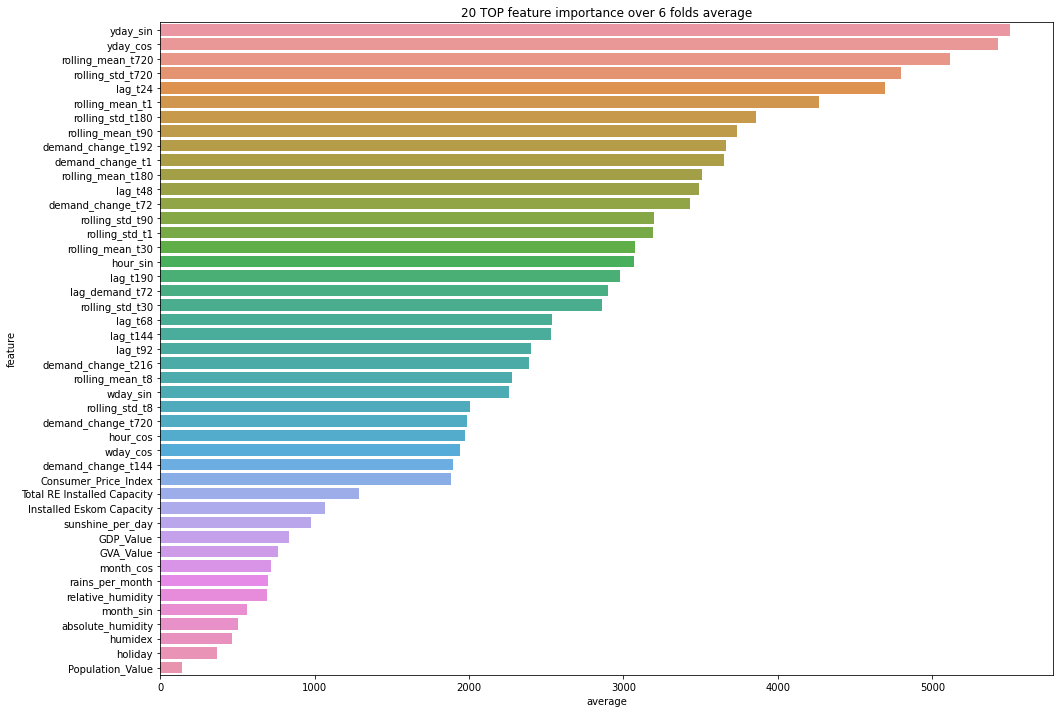

In [0]:
import seaborn as sns
import plotly.graph_objs as go
from matplotlib import pyplot as plt

feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)

feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 12))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('20 TOP feature importance over {} folds average'.format(folds.n_splits));

In [0]:
import plotly.graph_objs as go
import plotly.express as px


df = df.set_index('Date Time Hour Beginning')
df_filtered  = df[['Residual Forecast']]
eskom_test_forecast = test_x.merge(df_filtered, left_index=True, right_index=True, how='inner')
eskom_test_forecast['Residual Forecast'] = eskom_test_forecast['Residual Forecast'].astype(float)

fig = px.line(eskom_test_forecast, x=eskom_test_forecast.index, y=['demand', 'Residual Forecast', 'Residual Demand'],
              hover_data={"date": "|%B %d, %Y"},
              title='Residual Demand' )
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
    tickfont=dict(size=10),
    tickmode='auto',
    nticks=10,
    tickangle=45,
    showgrid=True,
    gridwidth=0.5,
    gridcolor='lightgrey',
    title_text="Date",
    title_font=dict(size=12),
    title_standoff=10)

fig.show()

In [0]:
import plotly.graph_objs as go

# df = df.set_index('Date Time Hour Beginning')
df_filtered  = df[['Residual Forecast']]
eskom_test_forecast = test_x.merge(df_filtered, left_index=True, right_index=True, how='inner')
eskom_test_forecast = eskom_test_forecast[:24]
eskom_test_forecast['Residual Forecast'] = eskom_test_forecast['Residual Forecast'].astype(float)


fig = px.line(eskom_test_forecast, x=eskom_test_forecast.index, y=['demand', 'Residual Forecast', 'Residual Demand'],
              hover_data={"date": "|%B %d, %Y"},
              title='Residual Demand vs Hectors Forecast' )
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
    tickfont=dict(size=10),
    tickmode='auto',
    nticks=10,
    tickangle=45,
    showgrid=True,
    gridwidth=0.5,
    gridcolor='lightgrey',
    title_text="Date",
    title_font=dict(size=12),
    title_standoff=10)

fig.show()

In [0]:
# Forecast into the Future
merged_df_dates_ = create_date_features(forecast_data)
merged_df_prices_ =  get_cpi_data(merged_df_dates_)
df_eco_ind_ = create_economic_indicator(merged_df_prices_)
df_eco_gva_ = create_gva_indicator(df_eco_ind_)
df_eco_population_ = create_population_indicator(df_eco_gva_)
df_merge_weather_ = get_weather_data(df_eco_population_)
df_merge_weather_null_ = data_cleansing_processing(df_merge_weather_)
df_cyclical_features_ = cyclical_variable(df_merge_weather_null_) 

for col in df_cyclical_features_.columns:
    if col.endswith('_x'):
        df_cyclical_features_ = df_cyclical_features_.rename(columns={col: col[:-2]})
        
df_cyclical_features_ = df_cyclical_features_.set_index('Date Time Hour Beginning')

demand_dataset_ = df_cyclical_features_[select_features]
demand_dataset_[float_features] = demand_dataset_[float_features].astype('float')

demand_dataset_ = demand_dataset_[columns] 

<command-4036840554340864>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
demand_dataset_

,Total RE Installed Capacity,Installed Eskom Capacity,Consumer_Price_Index,GDP_Value,GVA_Value,Population_Value,sunshine_per_day,rains_per_month,relative_humidity,absolute_humidity,...,wday_sin,wday_cos,yday_sin,yday_cos,month_sin,month_cos,hour_sin,hour_cos,holiday,demand
Date Time Hour Beginning,,,,,,,,,,,,,,,,,,,,,
2023-03-25 11:00:00 PM,6280.24,46686.0,24910.800034,6718015.0,97570.0,60605.0,7.4,6.31,63.0,11.4,...,-8.660254e-01,0.5,0.992222,0.124479,1.0,6.123234e-17,-2.449294e-16,1.000000,0,20833.515380
2023-03-25 23:00:00,6280.24,46686.0,24910.800034,6718015.0,97570.0,60605.0,7.4,6.31,63.0,11.4,...,-8.660254e-01,0.5,0.992222,0.124479,1.0,6.123234e-17,-2.449294e-16,1.000000,0,20304.987287
2023-03-26 00:00:00,6280.24,46686.0,24910.800034,6718015.0,97570.0,60605.0,7.4,6.31,63.0,11.4,...,-2.449294e-16,1.0,0.994218,0.107381,1.0,6.123234e-17,0.000000e+00,1.000000,0,19486.438813
2023-03-26 01:00:00,6280.24,46686.0,24910.800034,6718015.0,97570.0,60605.0,7.4,6.31,63.0,11.4,...,-2.449294e-16,1.0,0.994218,0.107381,1.0,6.123234e-17,2.697968e-01,0.962917,0,19399.046665
2023-03-26 02:00:00,6280.24,46686.0,24910.800034,6718015.0,97570.0,60605.0,7.4,6.31,63.0,11.4,...,-2.449294e-16,1.0,0.994218,0.107381,1.0,6.123234e-17,5.195840e-01,0.854419,0,19447.206208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31 08:00:00,6280.24,46686.0,24910.800034,6718015.0,97570.0,60605.0,7.4,6.31,63.0,11.4,...,-8.660254e-01,-0.5,0.999769,0.021516,1.0,6.123234e-17,8.169699e-01,-0.576680,0,22603.710417
2023-03-31 09:00:00,6280.24,46686.0,24910.800034,6718015.0,97570.0,60605.0,7.4,6.31,63.0,11.4,...,-8.660254e-01,-0.5,0.999769,0.021516,1.0,6.123234e-17,6.310879e-01,-0.775711,0,22572.615929
2023-03-31 10:00:00,6280.24,46686.0,24910.800034,6718015.0,97570.0,60605.0,7.4,6.31,63.0,11.4,...,-8.660254e-01,-0.5,0.999769,0.021516,1.0,6.123234e-17,3.984011e-01,-0.917211,0,22251.692995


In [0]:

columns = [
     
  feature for feature in select_features if feature not in ['date', 'Residual Demand']
  
]
splits = folds.split(train_x, train_y)
y_oof = np.zeros(train_x.shape[0])
y_forecast = np.zeros(demand_dataset_.shape[0])
feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
mean_score = []

In [0]:
# forecast for the features
for fold_n, (train_index, valid_index) in enumerate(splits):

    print('Fold:',fold_n+1)
    
    X_train, X_valid = train_x[columns].iloc[train_index], train_x[columns].iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    
    clf = lgb.train(params, dtrain, 2500, valid_sets = [dtrain, dvalid],early_stopping_rounds = 50, verbose_eval=100)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid,num_iteration=clf.best_iteration)
    y_oof[valid_index] = y_pred_valid
    
    val_score = np.sqrt(metrics.mean_squared_error(y_pred_valid, y_valid))
    
    print(f'val rmse score is {val_score}')
    
    mean_score.append(val_score)
    
    y_forecast += clf.predict(demand_dataset_[columns], num_iteration=clf.best_iteration)/n_fold
    del X_train, X_valid, y_train, y_valid
    

print('mean rmse score over folds is',np.mean(mean_score))
demand_dataset_['demand'] = y_forecast

Fold: 1
Training until validation scores don't improve for 50 rounds


/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[100]	training's rmse: 1423.52	valid_1's rmse: 1469.75
[200]	training's rmse: 853.652	valid_1's rmse: 1006.13
[300]	training's rmse: 660.126	valid_1's rmse: 884.011
[400]	training's rmse: 569.921	valid_1's rmse: 839.408
[500]	training's rmse: 509.65	valid_1's rmse: 817.514
[600]	training's rmse: 463.22	valid_1's rmse: 804.183
[700]	training's rmse: 427.81	valid_1's rmse: 795.465
[800]	training's rmse: 400.543	valid_1's rmse: 789.835
[900]	training's rmse: 377.604	valid_1's rmse: 787.05
[1000]	training's rmse: 358.016	valid_1's rmse: 785.285
[1100]	training's rmse: 340.951	valid_1's rmse: 784.386
[1200]	training's rmse: 326.183	valid_1's rmse: 783.354
Early stopping, best iteration is:
[1171]	training's rmse: 330.394	valid_1's rmse: 783.304
val rmse score is 783.3036355687932
Fold: 2
Training until validation scores don't improve for 50 rounds


/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[100]	training's rmse: 1376.68	valid_1's rmse: 2254.59
[200]	training's rmse: 812.473	valid_1's rmse: 1780.99
[300]	training's rmse: 621.833	valid_1's rmse: 1633.91
[400]	training's rmse: 536.948	valid_1's rmse: 1585.4
[500]	training's rmse: 479.437	valid_1's rmse: 1575.84
[600]	training's rmse: 435.588	valid_1's rmse: 1570.62
[700]	training's rmse: 400.422	valid_1's rmse: 1566.28
Early stopping, best iteration is:
[723]	training's rmse: 392.995	valid_1's rmse: 1565.42
val rmse score is 1565.4213786441462
Fold: 3
Training until validation scores don't improve for 50 rounds


/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[100]	training's rmse: 1426.85	valid_1's rmse: 1454.8
[200]	training's rmse: 819.371	valid_1's rmse: 979.626
[300]	training's rmse: 615.278	valid_1's rmse: 859.562
[400]	training's rmse: 526.098	valid_1's rmse: 832.496
[500]	training's rmse: 464.123	valid_1's rmse: 817.17
[600]	training's rmse: 420.127	valid_1's rmse: 813.633
[700]	training's rmse: 383.817	valid_1's rmse: 807.413
[800]	training's rmse: 355.445	valid_1's rmse: 804.742
Early stopping, best iteration is:
[803]	training's rmse: 354.592	valid_1's rmse: 804.653
val rmse score is 804.6528577698456
Fold: 4


/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1411.92	valid_1's rmse: 1355.52
[200]	training's rmse: 812.809	valid_1's rmse: 919.426
[300]	training's rmse: 612.958	valid_1's rmse: 813.765
[400]	training's rmse: 523.18	valid_1's rmse: 789.788
[500]	training's rmse: 462.691	valid_1's rmse: 786.63
Early stopping, best iteration is:
[454]	training's rmse: 488.758	valid_1's rmse: 784.814
val rmse score is 784.8140476535801
Fold: 5


/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1391.47	valid_1's rmse: 1345.07
[200]	training's rmse: 809.214	valid_1's rmse: 930.728
[300]	training's rmse: 615.437	valid_1's rmse: 824.006
[400]	training's rmse: 528.399	valid_1's rmse: 792.347
[500]	training's rmse: 467.732	valid_1's rmse: 780.237
[600]	training's rmse: 420.678	valid_1's rmse: 775.937
[700]	training's rmse: 381.282	valid_1's rmse: 774.385
Early stopping, best iteration is:
[741]	training's rmse: 367.423	valid_1's rmse: 773.836
val rmse score is 773.8364995200957
Fold: 6


/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/local_disk0/.ephemeral_nfs/envs/pythonEnv-d8e0f2ae-9e9b-4b25-a705-759ff822f72f/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1374.35	valid_1's rmse: 1300.49
[200]	training's rmse: 805.721	valid_1's rmse: 882.925
[300]	training's rmse: 616.904	valid_1's rmse: 776.495
[400]	training's rmse: 531.966	valid_1's rmse: 745.309
[500]	training's rmse: 471.155	valid_1's rmse: 733.076
[600]	training's rmse: 424.303	valid_1's rmse: 727.123
[700]	training's rmse: 384.485	valid_1's rmse: 723.941
Early stopping, best iteration is:
[746]	training's rmse: 368.666	valid_1's rmse: 723.49
val rmse score is 723.4903649222008
mean rmse score over folds is 905.9197973464435


In [0]:
evaluation_dataset['Date Time Hour Beginning'] = pd.to_datetime(evaluation_dataset['Date Time Hour Beginning'])
evaluation_dataset = evaluation_dataset.set_index('Date Time Hour Beginning')
evaluation_dataset = evaluation_dataset[['Residual Forecast']]

In [0]:
demand_dataset_write = demand_dataset_.merge(evaluation_dataset, left_index=True, right_index=True, how='inner')[['demand', 'Residual Forecast']]

In [0]:
# TOD0:
   # Only write weekly forecast/ Pagination on the backend. We overwite weekly forecast. use static site generation  on NextJS 

In [0]:
def database_writer(dataframe, table_name):
  
  display(dataframe)
  
  pyspark_df = spark.createDataFrame(dataframe)
  
  mode = "overwrite"
  url = ""
  properties = {"user": "postgres","password": "","driver": "org.postgresql.Driver"}
  
  pyspark_df.write.jdbc(url=url, table=table_name, mode=mode, properties=properties)

In [0]:
# Write Installed Capacity to the Database

df_write = df.tail(1)[[ 'Wind Installed Capacity',  'Installed Eskom Capacity', 'CSP Installed Capacity']].reset_index()

df_write = df_write.rename(columns={
  'Wind Installed Capacity': 'Wind Installed Capacity',
  'Installed Eskom Capacity': 'Installed Eskom Capacity',
  'CSP Installed Capacity': 'CSP Installed Capacity'
})

database_writer(df_write, 'energycapacity')

Date Time Hour Beginning,Wind Installed Capacity,Installed Eskom Capacity,CSP Installed Capacity
2023-03-25 11:00:00 PM,3442.57,46686.0,500.0


In [0]:
# Write the hourly data to Database

demand_dataset_write.reset_index(inplace=True)

demand_dataset_write = demand_dataset_write.rename(columns={
  'demand': 'Residual Demand Forecast',
  'Residual Forecast': 'Eskom Residual Forecast',
})

database_writer(demand_dataset_write, 'hourlyforecasts')

Date Time Hour Beginning,Residual Demand Forecast,Eskom Residual Forecast
2023-03-26T00:00:00.000+0000,19486.43881286445,19835.072
2023-03-26T01:00:00.000+0000,19399.046664869173,19485.019
2023-03-26T02:00:00.000+0000,19447.20620763007,19391.842
2023-03-26T03:00:00.000+0000,19766.062627667154,19319.153
2023-03-26T04:00:00.000+0000,20548.000375809665,19706.524
2023-03-26T05:00:00.000+0000,21166.95986441591,20124.79
2023-03-26T06:00:00.000+0000,21931.840191099083,21184.153
2023-03-26T07:00:00.000+0000,23229.887102487493,22719.258
2023-03-26T08:00:00.000+0000,23266.847459825214,23623.678
2023-03-26T09:00:00.000+0000,23200.06152173307,23471.706


In [0]:
# Weekly Forecast / Get the Actual Demand from previous week and merge with forecast/prediction for next week
merge_prediction_dataset = pd.concat([test_x[['Residual Demand']], demand_dataset_write[['demand']]])

merge_prediction_dataset_ = merge_prediction_dataset.rename(columns={'demand':'Forecast Demand'})

merge_prediction_dataset_ = merge_prediction_dataset_.reset_index()

merge_prediction_dataset_date = merge_prediction_dataset_.rename(columns={'index':'Date Time Hour Beginning'})

merge_prediction_dataset_date['Date Time Hour Beginning'] = pd.to_datetime(merge_prediction_dataset_date['Date Time Hour Beginning'])

Out[275]: <AxesSubplot:>

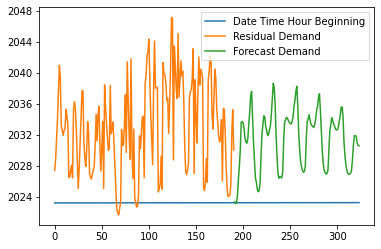

In [0]:
merge_prediction_dataset_date.plot()

In [0]:
# Write the day data to Database Forecasts to the Database

database_writer(merge_prediction_dataset_date, "weeklyforecasts")

Date Time Hour Beginning,Residual Demand,Forecast Demand
2023-03-18T00:00:00.000+0000,20963.497,null
2023-03-18T23:00:00.000+0000,21477.136,null
2023-03-18T22:00:00.000+0000,22435.372,null
2023-03-18T21:00:00.000+0000,23406.269,null
2023-03-18T20:00:00.000+0000,24700.084,null
2023-03-18T19:00:00.000+0000,25909.943,null
2023-03-18T18:00:00.000+0000,25320.317,null
2023-03-18T16:00:00.000+0000,23070.397,null
2023-03-18T15:00:00.000+0000,22882.196,null
2023-03-18T14:00:00.000+0000,22618.884,null
